### LeNet
In this notebook we will expand the multilayer-perceptron (MLP) and implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) in MNIST digits classification.

<p align="center">
<img src="https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1"/>
</p>

### Data processing
As usual we will import necessary packages and prepare our mnist digit classifier using the LeNet-5 achitecture

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils import data
import random, time, os, copy

import numpy as np
import matplotlib.pyplot as plt

from sklearn import decomposition, manifold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from prettytable import PrettyTable

### Setting seeds

In [2]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True

### Calculating the mean and the standard deviation for our data

In [3]:
train_data = datasets.MNIST(
    '.', train=True, download=True
)

mean = train_data.data.float().mean()/255
std = train_data.data.float().std()/255


def tabulate(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

tabulate([
    "Measure of Central Tendecy", "Value"
],[
   ("mean", mean.item()),
   ("standard dev (std)", std.item())
], "THE MEAN AND STANDARD DEVIATION OF THE DATA")

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


+--------------------------------------------------+
|   THE MEAN AND STANDARD DEVIATION OF THE DATA    |
+----------------------------+---------------------+
| Measure of Central Tendecy |               Value |
+----------------------------+---------------------+
| mean                       | 0.13066047430038452 |
| standard dev (std)         | 0.30810779333114624 |
+----------------------------+---------------------+


### Data transformation.

In [4]:
train_transforms = transforms.Compose([
        transforms.RandomRotation(5, fill=(0, )),
        transforms.RandomCrop(28, padding=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std], inplace=False)
])

test_transforms = transforms.Compose([
         transforms.ToTensor(),
        transforms.Normalize(mean=[mean], std=[std], inplace=False)  
])

### Loading the data

In [5]:
train_data = datasets.MNIST('.',
                            train= True,
                            download=True,
                            transform=train_transforms
                            )
test_data = datasets.MNIST('.', 
                           train=False,
                           download=True,
                           transform=test_transforms
                           )

### Creating a `validation` set from the train set.
We will create a validation set from our train set as usual and then overide the train transforms, and make sure that we use a `deepcopy` when taking example from the train data so that when overriding the transformations we dont overide train transformations as well.

In [6]:
n_valid = int(len(train_data) * 0.1)
n_train = len(train_data) - n_valid
train_data, valid_data = data.random_split(train_data, [n_train, n_valid])

### Checking how many examples for each set.

In [7]:
title = "DATASETS EXAMPLES"
columns = "SET", "TOTAL"
data_rows = ("training", len(train_data)), ("testing", len(test_data)), ("validation", len(valid_data))
tabulate(columns, data_rows, title)

+--------------------+
| DATASETS EXAMPLES  |
+------------+-------+
| SET        | TOTAL |
+------------+-------+
| training   | 54000 |
| testing    | 10000 |
| validation |  6000 |
+------------+-------+


In [8]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

### Creating iterators
Again we are going to use the `DataLoader` to create iterators for 

In [9]:
BATCH_SIZE = 64
train_iterator = data.DataLoader(
    train_data, shuffle=True,
    batch_size = BATCH_SIZE
)
test_iterator = data.DataLoader(
    test_data,
    batch_size = BATCH_SIZE
)
valid_iterator = data.DataLoader(
    valid_data,
    batch_size = BATCH_SIZE
)

### Defining a model.

The LeNet architectures, and almost every modern neural network computer vision architecture makes use of convolutional neural network (CNN) layers.

So, what is a CNN layer? Each convolutional layer has a number of filters, also commonly referred to as kernels. A filter is a (usually) square matrix that slides across the pixels in an image from left-to-right, top-to-bottom. At each "step", the filter performs a convolution operation on the image. The output of the convolutional layer is the result of these convolutions after the filter's final "step".

Note: in machine learning frameworks there aren't actually "steps", the result for every filter location is calculated at the same time, in parallel. This is a lot faster than actually stepping through the image, but thinking about it in terms of steps makes everything easier to visualize.

Let's have a look at a single 2x2 filter passing over an image. We'll pretend the image is 10x10 pixels in this example.

<p align="center">
<img src="https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/filter-mnist.png?raw=1"/>
</p>

The filter (red) slides over the pixels of the image, stepping one pixel at a time. The size of the steps is called the stride, and we use a stride of one in this implementation, which means the filter moves one pixel at a time horizontally and moves one pixel down once it reaches the end of a row. The result of the convolution operation (green) is a pixel in the filtered image. All of these convolutions produce a new, filtered image.

Notice how the image coming out of the CNN layer is smaller than the image coming into the CNN. This is because the 2x2 filter has only nine steps horizontally and vertically. If we wanted to keep the output image the same size as the input image we could add padding - usually black pixels - around our image.

When we have no padding and a step size of one, the size of the output image is:

heightout=heightin−filterheight+1
widthout=widthin−filterwidth+1
How do we calculate the values of the output pixels using the filter? It's simply a multiply and add! Each of the input image pixels covered by a filter is multiplied by the filter's weight over that pixel. All of these products are then summed together to get the value of the pixel in the output image.


<p align="center">
<img src="https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-filter.png?raw=1"/>
</p>

The same weights are used by the filter over the whole image. The weights do not change depending on the filters location within the image. One nice thing about this is that that the filters (and the convolutional layers themselves) are translation invariant, that means it doesn't matter where a feature (curve, edge, line) appears in an image, the convolutional layer will find all occurences of it.

The weights for the filters, much like the weights of the linear layers in multilayer perceptrons, are learned via gradient descent and backpropagation.

Why are convolutional neural networks structured in this way? Filters applied across an image in this way can be used to detect patterns such as horizontal and vertical lines within an image. These patterns can be thought of as features of the image, which our CNN extracts. These extracted features can then be combined in further layers of the neural network with other extracted features and together create higher level features, e.g. a certain position and orientation of two lines make a cross, which can indicate the centre of a handwritten 4.

CNNs are also inspired by classic computer vision techniques, like Sobel filters. Let's try manually choosing weights of a 3x3 filter to make Sobel filters and apply them to some of the MNIST digits to see what type of things our CNN layers can learn.

The `plot_filter` function takes in a batch of images and a two-dimensional filter and plots the output of that filter applied to all of the images.


In [10]:
def plot_filter(images, filter):
  images = images = torch.cat([i.unsqueeze(0) for i in images], dim=0).cpu()
  filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
  n_images = images.shape[0]
  filtered_images = F.conv2d(images, filter)
  fig = plt.figure(figsize = (20, 5))
  for i in range(n_images):
    ax = fig.add_subplot(2, n_images, i+1)
    ax.imshow(images[i].squeeze(0), cmap = 'bone')
    ax.set_title('Original')
    ax.axis('off')

    image = filtered_images[i].squeeze(0)

    ax = fig.add_subplot(2, n_images, n_images+i+1)
    ax.imshow(image, cmap='bone')
    ax.set_title(f'Filtered')
    ax.axis('off');


We'll then get a batch of images to test our handwritten Sobel filters on. We get the images from the test set as they're easier to examine without the transforms applied to them.

In [11]:
N_IMAGES = 5
images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

The first filter is for detecting horizontal lines.

We can see on the filtered images that the highest values (the whitest pixels) of the filtered image are where there is a horizontal line that is black on top and white below, e.g. the top of the 7 digit. The lowest values (the blackest pixels) of the filtered image are where there is a horizontal line that goes from white to black, e.g. the bottoms of all of the digits.

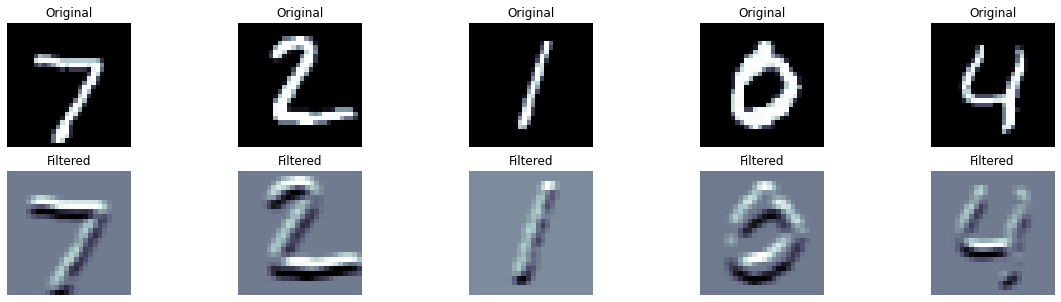

In [12]:
horizontal_filter = [[-1, -2, -1],
                     [ 0,  0,  0],
                     [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

By swapping the first and last rows of the above filter, we get a filter that detects horizontal lines from white on top to black underneath.

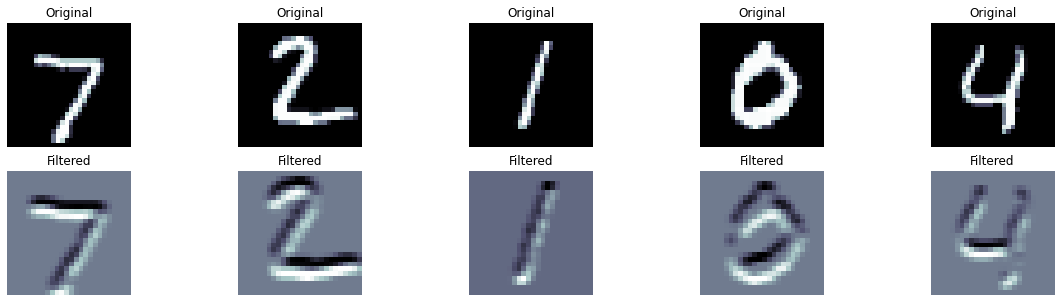

In [13]:
horizontal_filter = [[ 1,  2,  1],
                     [ 0,  0,  0],
                     [-1, -2, -1]]

plot_filter(images, horizontal_filter)

We can also design filters that detect vertical lines.

Here's one that detects vertical lines that are black on the left and white on the right.

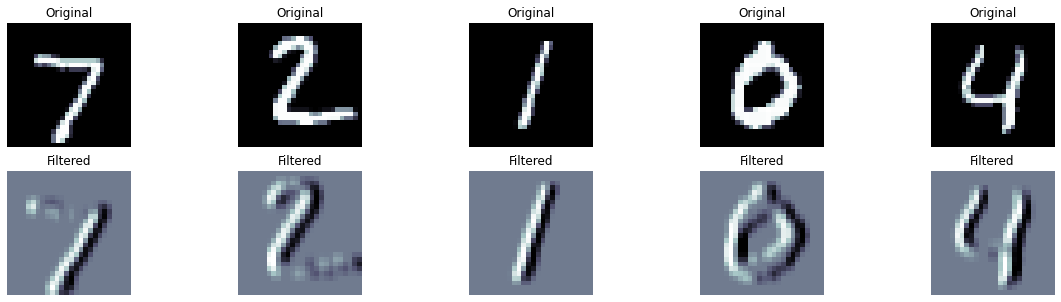

In [14]:
vertical_filter = [[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]]

plot_filter(images, vertical_filter)

To get the opposite filter, one that detects vertical lines that are white on the left and black on the right, we swap the left and right columns.

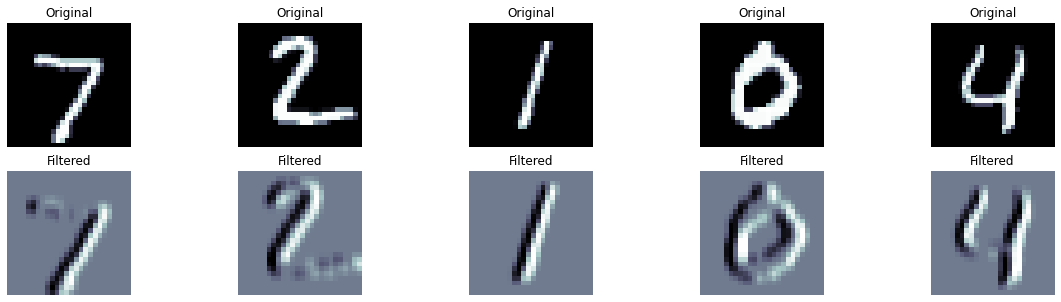

In [15]:

vertical_filter = [[1, 0, -1],
                   [2, 0, -2],
                   [1, 0, -1]]

plot_filter(images, vertical_filter)

The great thing about convolutional layers is that each layer doesn't just have a single filter. It has as many filters as you want. Each filter has their own set of weights, so (in theory) is learning to extract different features.

The image below shows what happens when we use a convolutional layer with five filters. The original image with a single color channel (as it's black and white) has five filters applied to it to get five filtered images. These images are then stacked together to get what we can think of as a single image with five channels.

<p align="center"> <img src="https://camo.githubusercontent.com/c7c3b9e2cac60b19eb795f631900d40eb959fa8a/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f6d756c7469706c652d66696c7465722d6d6e6973742e706e673f7261773d31"/></p>

What about when you now want to pass this five channel filtered image to another convolutional layer? Now, that convolutional layer won't just have a height and a width, but it will also have a depth equal to the number of channels in the input image.

<p align="center">
<img src="https://camo.githubusercontent.com/9ab4463a7c511ad0d4d0b9bed65995cf9cbc1028/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f6d756c7469706c652d6368616e6e656c2d6d6e6973742e706e673f7261773d31"/>
</p>

As you can see, the filter has a height, width and depth of 2x2x5. All of the 20 pixel values covered by this filter are multiplied by the filter's weight and then summed. The result of this will have as many channels as there are filters, and a subsequent convolutional layer will have to have filters with a depth equal to that number of channels.

Hopefully that's enough on convolutional layers, but if not then there are plenty of other resources about them online.

Next, we'll talk about the subsampling layers. These are layers used to reduce the size/resolution of their input and are commonly applied to the output of convolutional layers. The most common two methods of subsampling are max pooling and mean pooling (also known as average pooling), and thus subsampling is often know as pooling.

Why do we want to reduce the resolution of the image? It speeds up our model, as convolution operations are expensive. If we subsample and half the size of our image before it passes into the next convolutional layer, that's a significant speed up.

Subsampling layers aren't too different to convolutional layers. They have a filter with a size and a stride. However, pooling layers do not have any parameters - weights and biases. They simply perform an operation on the image. Max pooling returns the maximum of the values covered by the filter and we can think of it as extracting the single most important feature under the filter. Mean/average pooling returns the mean/average of the values covered by the filter and we can think of it as equally weighting all features under the filter.

Let's look at a 2x2 pooling operation, with a stride of 2, over an image:

<p align="center">
<img src="https://camo.githubusercontent.com/0f79ace05e5a9cb7349e80f6b3108c7443a29814/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f73756273616d706c652d6d6e6973742e706e673f7261773d31"/>
</p>
Commonly, and by default in PyTorch, the stride for the height and the width is the height and the width of the filter and each pixel is only seen by the pooling layer once, thus:

$$\text{height}_{\text{out}} = \frac{\text{height}_\text{in}}{\text{filter}_{\text{height}}}$$$$\text{width}_{\text{out}} = \frac{\text{width}_\text{in}}{\text{filter}_{\text{width}}}$$
For max pooling, the value of the output for each filter location is:

<p align="center">
<img src="https://camo.githubusercontent.com/c0cd59ed830fd46b799e21f97f124287b8467e0d/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f73696e676c652d706f6f6c2e706e673f7261773d31"/>
</p>

Let's create a function that allows us to see the outputs of a pooling layer on a batch of images

In [16]:
def plot_subsample(images, pool_type, pool_size):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    
    if pool_type.lower() == 'max':
        pool = F.max_pool2d
    elif pool_type.lower() in  ['mean', 'avg']:
        pool = F.avg_pool2d
    else:
        raise ValueError(f'pool_type must be either max or mean, got: {pool_type}')
    
    n_images = images.shape[0]

    pooled_images = pool(images, kernel_size = pool_size)

    fig = plt.figure(figsize = (20, 5))
    
    for i in range(n_images):

        ax = fig.add_subplot(2, n_images, i+1)
        ax.imshow(images[i].squeeze(0), cmap='bone')
        ax.set_title('Original')
        ax.axis('off')

        image = pooled_images[i].squeeze(0)

        ax = fig.add_subplot(2, n_images, n_images+i+1)
        ax.imshow(image, cmap='bone')
        ax.set_title(f'Subsampled')
        ax.axis('off');
        

First, let's see max pooling with a filter size of 2.

We can see that the image is heavily downsampled - reduced in size/resolution and in quality.



/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


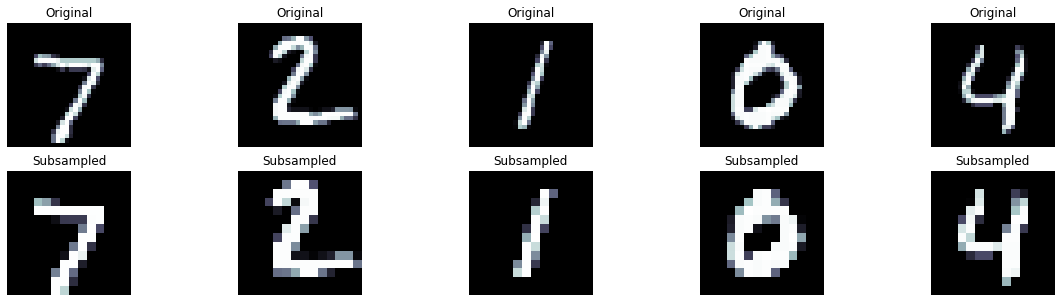

In [17]:
plot_subsample(images, 'max', 2)

If we increase the size of the max pooling filter the images get smaller and the quality gets worse.

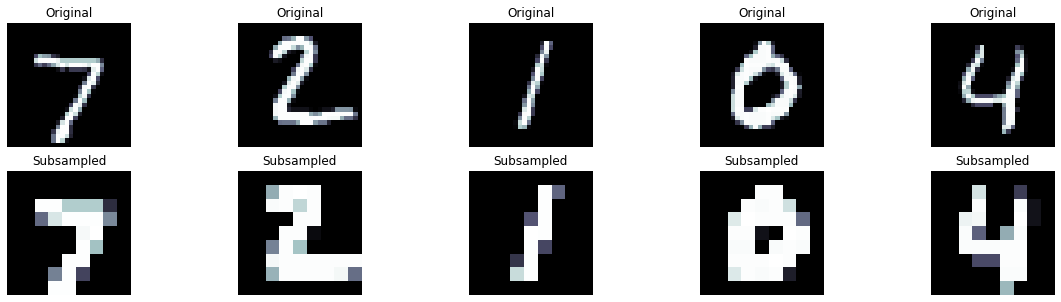

In [18]:
plot_subsample(images, 'max', 3)

For average pooling, the same effect happens, however the loss in quality is not as harsh.

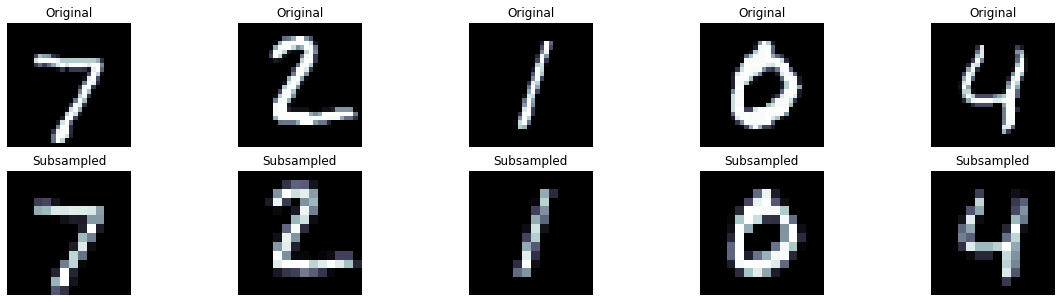

In [19]:
plot_subsample(images, 'avg', 2)

Again, we can increase the filter size, reducing the resolution of the output image at the cost of image quality - however the quality drop is not as bad as max pooling.

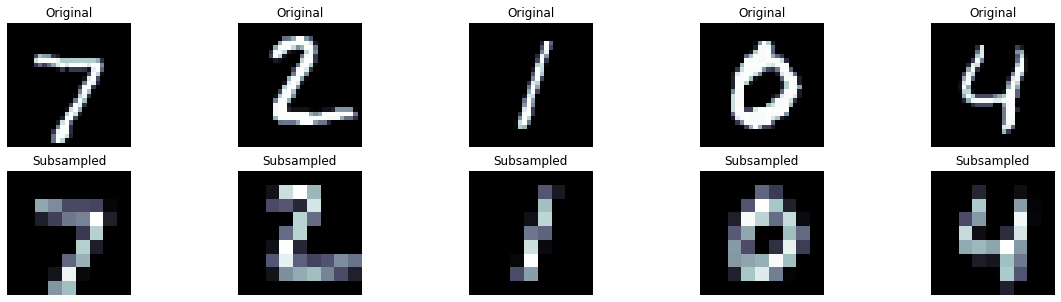

In [20]:
plot_subsample(images, 'avg', 3)

Similarly to convolutional layers, if the input image has more than one channel, the filter has a depth equal to the number of channels. Thus, if we did a max pool with a 5x5x6 filter (height and width of 5 and depth of 6), the output at each pixel would be the maximum value of all 150 pixels covered by the filter.

### Defining the Model
Now we've gone through all of the concepts we can implement our model.
<p align="center"><img src="https://camo.githubusercontent.com/0f2b54062770fd0f7c65c20be680b73016168e05/68747470733a2f2f6769746875622e636f6d2f62656e747265766574742f7079746f7263682d696d6167652d636c617373696669636174696f6e2f626c6f622f6d61737465722f6173736574732f6c656e6574352e706e673f7261773d31"/></p>

Our actual implementation is going to slightly differ from the actual LeNet architecture as it was built to handle 32x32 images, whereas the MNIST dataset consists of 28x28 images. We're also not going to use the Gaussian connections at the end, instead we'll just use a standard linear layer.

The first layer in our model is convolutional layer with 6 filters (PyTorch calls them out_channels) and a kernel size of 5. This turns our ``[1, 28, 28]`` image into ``[6, 24, 24]``. 
```
width = width - filter_size(out_channels) + 1
height = height - filter_size(out_channels)  + 1
```
We then downsample our image with a max pooling layer that has a filter size of 2 to get a `[6, 12, 12]` image. This is then passed through an activation function, ReLU in this case, which is applied elementwise and does not change the of the image.

Afterwards, we pass the image to the second convolutional layer with 16 filters that are `5x5x6`, a height and width of `5` and a depth of `6` as our previous convolutional layer had 6 filters. This gives us an image size of `[16, 8, 8]` which we then max pool to half the heigth and width to `[16, 4, 4]` and then pass through another `ReLU` function.

We then flatten our `[16, 4, 4]` image to `[256]` and pass this through three linear layers. Each of the linear layers are followed by another ReLU, except for the last.

We return the results from the final linear layer as well as from the flattened result of the second convolutional layer, which we can plot in lower dimensions later.

**Note that you should always apply your activation function after the pooling layer**. You will get the exact same results if you apply the activation function before, however this means you will be applying your activation function to a larger number of inputs, increasing the computation required. Using the activation function after the image has been reduced in size means it will be applied to less inputs and thus use less computation.



In [51]:
class LeNet(nn.Module):
  def __init__(self, output_dim):
    super(LeNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1,
                           out_channels=6,
                           kernel_size =5
                           )
    self.conv2 = nn.Conv2d(in_channels=6,
                           out_channels=16,
                           kernel_size = 5
                           )
    self.fc_1 = nn.Linear(16 * 4 * 4, 120)
    self.fc_2 = nn.Linear(120, 84)
    self.fc_3 = nn.Linear(84, output_dim)

  def forward(self, x):
    # x = [batch size, 1, 28, 28]
    x = self.conv1(x)
    # x = [batch size, 6, 24, 24]
    x = F.max_pool2d(x, kernel_size = 2)
    # x = [batch size, 6, 12, 12]
    x = F.relu(x)
    x = self.conv2(x)
    # x = [batch size, 16, 8, 8]
    x = F.max_pool2d(x, kernel_size = 2)
    # x = [batch size, 16, 4, 4]
    x = F.relu(x)
    x = x.view(x.shape[0], -1) # x = [batch size, 16*4*4 = 256]
    h = x
    x = self.fc_1(x) # x = [batch size, 120]
    x = F.relu(x)
    x = self.fc_2(x) # x = batch size, 84]
    x = F.relu(x)
    x = self.fc_3(x)
    # x = [batch size, output dim]
    return x, h

Then the rest of the notwbook is similar to the previous ones. Let's create our model.

### Device

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else'cpu')
device

device(type='cuda')

In [63]:
OUTPUT_DIM = 10

mnist_lenet = LeNet(OUTPUT_DIM).to(device)
mnist_lenet

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=256, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=10, bias=True)
)

### Conting parameters of the model.

In [54]:
def count_params(model):
  total_params = sum([p.numel() for p in model.parameters()])
  trainable_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
  tabulate(["","Parameters"], 
           [["total parameters", f'{total_params:,}'],
            ["trainable parameters", f'{trainable_params:,}']],
           "MODEL PARAMETERS"
           )
  
count_params(model=mnist_lenet)

+-----------------------------------+
|          MODEL PARAMETERS         |
+----------------------+------------+
|                      | Parameters |
+----------------------+------------+
| total parameters     |     44,426 |
| trainable parameters |     44,426 |
+----------------------+------------+


### Optimizer and loss function.

In [64]:
optimizer = torch.optim.Adam(mnist_lenet.parameters())
criterion = nn.CrossEntropyLoss().to(device)

### Categorical accuracy function.

In [65]:
def categorical_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/ y.shape[0]
  return acc

### Training and Evaluation function.

In [66]:
def train(model, iterator, optimizer, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.train()
  for (x, y) in iterator:
    # features and labels to the device
    x = x.to(device)
    y = y.to(device)
    # Zero the gradients
    optimizer.zero_grad()
    y_pred, _ = model(x)
    # Calculate the loss and accuracy
    loss = criterion(y_pred, y)
    acc = categorical_accuracy(y_pred, y)
    # Backward propagate
    loss.backward()
    # Update the weights
    optimizer.step()

    epoch_loss +=loss.item()
    epoch_acc += acc.item()

  return epoch_loss/len(iterator), epoch_acc/len(iterator)

def evaluate(model, iterator, criterion, device):
  epoch_loss, epoch_acc = 0, 0
  model.eval()
  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)
      y = y.to(device)
      y_pred, _ = model(x)
      loss = criterion(y_pred, y)
      acc = categorical_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Visualize training

In [67]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [68]:
def tabulate_training(column_names, data, title):
  table = PrettyTable(column_names)
  table.title= title
  table.align[column_names[0]] = 'l'
  table.align[column_names[1]] = 'r'
  table.align[column_names[2]] = 'r'
  table.align[column_names[3]] = 'r'
  for row in data:
    table.add_row(row)
  print(table)

In [69]:
EPOCHS = 20
best_valid_loss = float('inf')
column_names = ["Set", "Loss", "Accuracy", "ETA (time)"]
for epoch in range(EPOCHS):
  start = time.time()

  train_loss, train_acc = train(mnist_lenet, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(mnist_lenet, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(mnist_lenet.state_dict(), 'best-model.pt')
  end = time.time()

  data_rows = [
      ["Train", f'{train_loss:.3f}', f'{train_acc * 100:.2f}%', hms_string(end-start)],
      ["Validation", f'{valid_loss:.3f}', f'{valid_acc * 100:.2f}%', ""]
  ]
  title = f"EPOCH {epoch+1:02}/{EPOCHS}"
  tabulate_training(column_names, data_rows, title)

+--------------------------------------------+
|                EPOCH 01/20                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.363 |   88.39% | 0:00:28.40 |
| Validation | 0.094 |   97.09% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|                EPOCH 02/20                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      | 0.109 |   96.59% | 0:00:28.29 |
| Validation | 0.073 |   97.82% |            |
+------------+-------+----------+------------+
+--------------------------------------------+
|                EPOCH 03/20                 |
+------------+-------+----------+------------+
| Set        |  Loss | Accuracy | ETA (time) |
+------------+-------+----------+------------+
| Train      

In [70]:
mnist_lenet.load_state_dict(torch.load('best-model.pt'))

test_loss, test_acc = evaluate(mnist_lenet, test_iterator, criterion, device)
title = "Model Evaluation Summary"
data_rows = [["Test", f'{test_loss:.3f}', f'{test_acc * 100:.2f}%', ""]]

tabulate_training(column_names, data_rows, title)

+--------------------------------------+
|       Model Evaluation Summary       |
+------+-------+----------+------------+
| Set  |  Loss | Accuracy | ETA (time) |
+------+-------+----------+------------+
| Test | 0.027 |   99.19% |            |
+------+-------+----------+------------+


### Making predictions and plotting them.

In [72]:
def get_predictions(model, iterator, device):
    model.eval()
    images = []
    labels = []
    probs = []
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred, _ = model(x)
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())
    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)
    return images, labels, probs

In [75]:
images, labels, probs = get_predictions(mnist_lenet, test_iterator, device)

In [91]:
pred_labels = torch.argmax(probs, 1)
pred_labels

tensor([7, 2, 1,  ..., 4, 5, 6])

In [96]:
def plot_predictions_images(images, labels_true,
                            labels_pred, cols=5, rows = 3):
    fig = plt.figure()
    fig.set_size_inches(cols * 2, rows * 2)
    for i, (image, label_true, label_pred) in enumerate(zip(images, labels_true, labels_pred)):
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.imshow(image[0, :, :], cmap="gray")
  
        plt.title(label_pred.item(), color ='g' if label_true == label_pred else 'r', fontsize=16 )

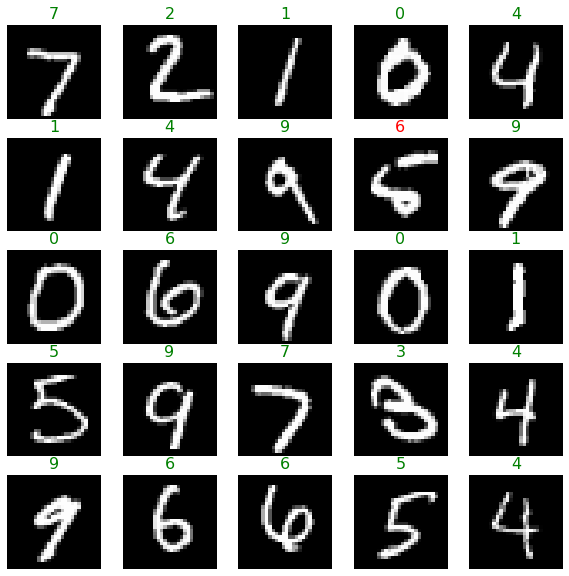

In [98]:
plot_predictions_images(images[:25], labels[:25], pred_labels[:25], rows=5)

### PLot confusion matrix.

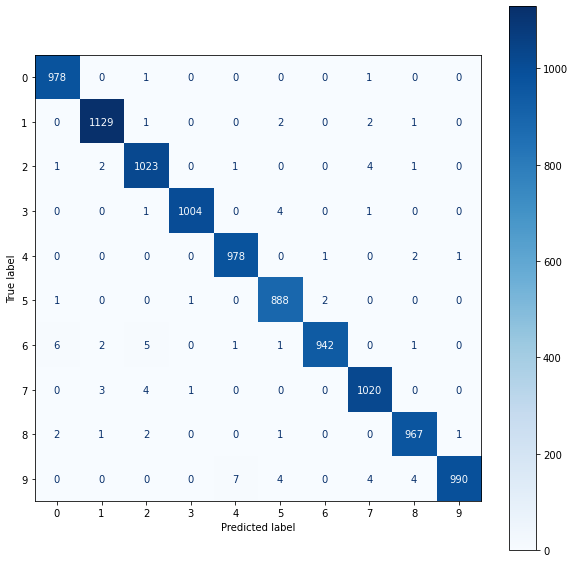

In [99]:
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

plot_confusion_matrix(labels, pred_labels)

Next, we'll find out which of our examples are correct...



In [100]:
corrects = torch.eq(labels, pred_labels)

...then get all of the incorrect examples and sort them by descending confidence in their prediction.

In [101]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

We can then use this to plot the examples the model got wrong and was most confident about.

In [102]:

def plot_most_incorrect(incorrect, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap = 'bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

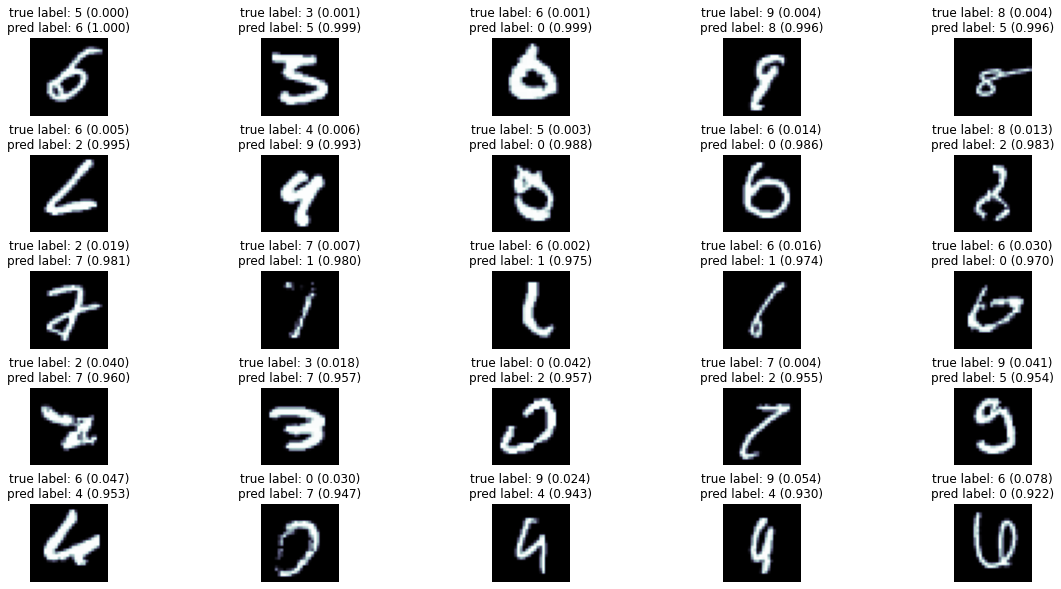

In [103]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [104]:
def get_representations(model, iterator, device):
  model.eval()
  outputs = []
  intermediates = []
  labels = []

  with torch.no_grad():
      
      for (x, y) in iterator:

          x = x.to(device)

          y_pred, h = model(x)

          outputs.append(y_pred.cpu())
          intermediates.append(h.cpu())
          labels.append(y)
      
  outputs = torch.cat(outputs, dim = 0)
  intermediates = torch.cat(intermediates, dim = 0)
  labels = torch.cat(labels, dim = 0)

  return outputs, intermediates, labels

In [106]:
outputs, intermediates, labels = get_representations(mnist_lenet, train_iterator, device)

...and then calculate PCA on the representations.

In [107]:
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data


We then plot the PCA representations.

Similar to the previous notebooks, even when the classes overlapped in the PCA representations the confusion matrix showed that they weren't mixed up often at all.

In [108]:
def plot_representations(data, labels, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    handles, labels = scatter.legend_elements()
    legend = ax.legend(handles = handles, labels = labels)

In [109]:
output_pca_data = get_pca(outputs)

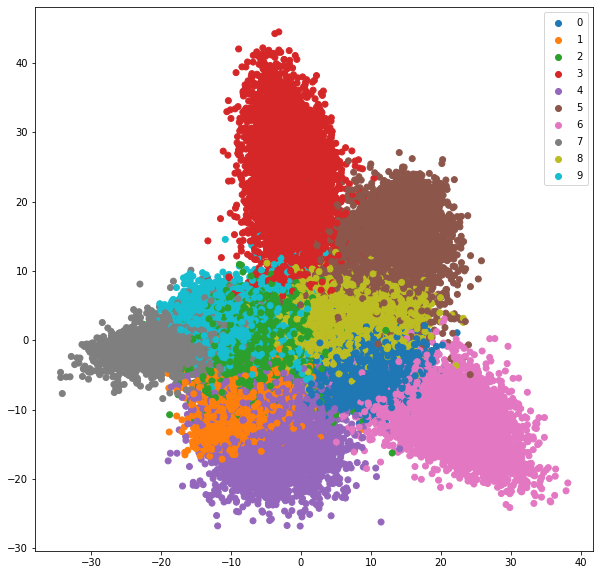

In [110]:
plot_representations(output_pca_data, labels)

Plotting the PCA representations of the intermediate values, just after the second set of convolutional and subsampling layers.

We can see that a lot of the classes are overlapped in one giant cluster. Intuitively, this makes sense as the model has only extracted the features of the image so far and not yet passed them to the linear layers that will weight these features to make an actual prediction.

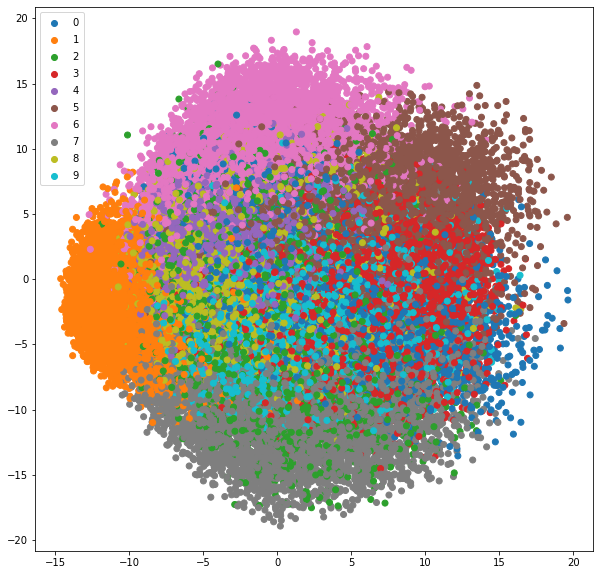

In [111]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

We repeat the process for t-SNE. Again, we only use a subset of the data as t-SNE takes a considerable amount of time.

In [112]:

def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

First, the output representations. t-SNE does a good job on separating out the classes.

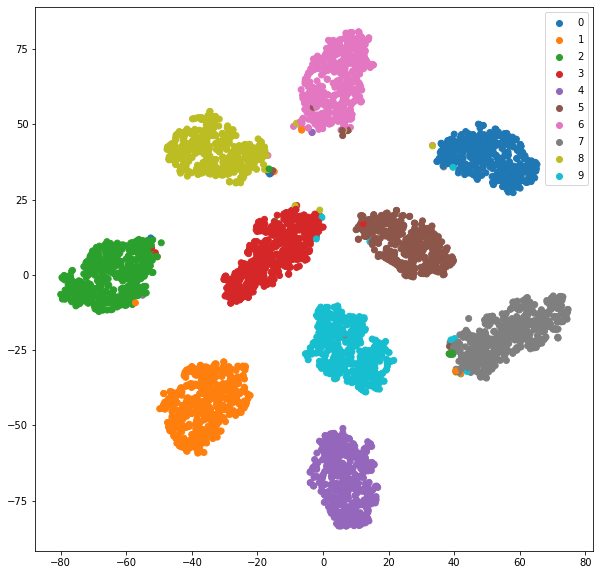

In [113]:
N_IMAGES = 5_000
output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, n_images = N_IMAGES)


Again, the intermediate representations are more clustered which adds more evidence to the theory that this is just a representation of the extracted features before the linear layers have had a chance to weight up evidence on the presence or absence of certain extracted features.

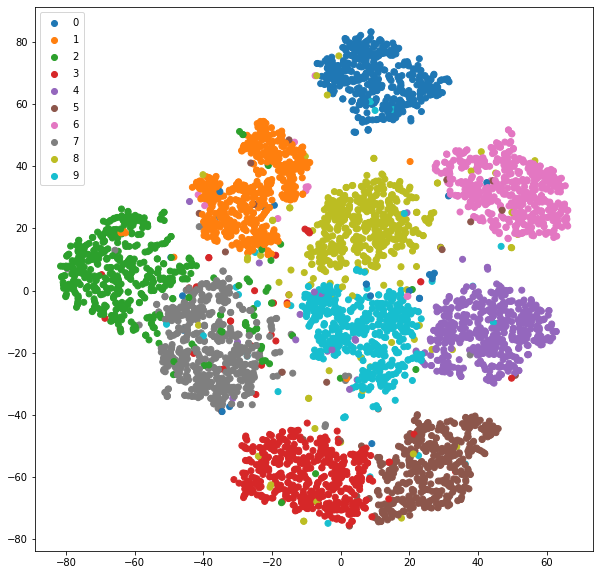

In [114]:
intermediate_tsne_data = get_tsne(intermediates, n_images = N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images = N_IMAGES)

As before, we can try generating a perfect handwritten digit by repeatedly generating a batch of noise and storing the noise that gave us the highest probability of being the digit we want.

Surely as we now have convolutional layers that look for edges and curves we should get something more sensible, right?

In [115]:
def imagine_digit(model, digit, device, n_iterations = 50_000):

    model.eval()
    
    best_prob = 0
    best_image = None

    with torch.no_grad():
    
        for _ in range(n_iterations):

            x = torch.randn(32, 1, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = F.softmax(y_pred, dim = -1)

            _best_prob, index = torch.max(preds[:,digit], dim = 0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

As we can see below, no. We get random noise with a >99% confidence that it's a three.

Again, our model has been trained to be confident in its predictions and thus will be even for random noise. This is a flaw of neural networks and is a reason why adversarial examples work so well.

In [117]:
DIGIT = 3

best_image, best_prob = imagine_digit(mnist_lenet, DIGIT, device)

print(f'Best image probability: {best_prob.item()*100:.2f}%')

Best image probability: 99.94%


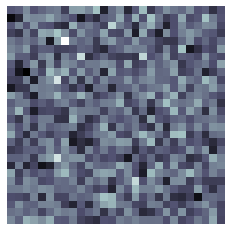

In [118]:
plt.imshow(best_image.squeeze(0).cpu().numpy(), cmap = 'bone')
plt.axis('off');

Remember how we defined the Sobel filters early on in this notebook? Well, as convolutional layers learn their own values for their filters we can do the same thing and see how our filters process images.

Let's define a function that takes a batch of images and multiple filters which it then uses on the images.

In [119]:
def plot_filtered_images(images, filters):

    images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
    filters = filters.cpu()

    n_images = images.shape[0]
    n_filters = filters.shape[0]

    filtered_images = F.conv2d(images, filters)

    fig = plt.figure(figsize = (20, 10))

    for i in range(n_images):

        ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters))
        ax.imshow(images[i].squeeze(0), cmap = 'bone')
        ax.set_title('Original')
        ax.axis('off')

        for j in range(n_filters):
            image = filtered_images[i][j]
            ax = fig.add_subplot(n_images, n_filters+1, i+1+(i*n_filters)+j+1)
            ax.imshow(image.numpy(), cmap = 'bone')
            ax.set_title(f'Filter {j+1}')
            ax.axis('off');

Some of our filters look for areas of black pixels, which has the effect of inverting our images. Some apply a blur effect which is is similar to Gaussian blur effects used in image processing to reduce noise in the image. Some detect edges like our Sobel filters we created earlier.

There is no guarantee each filter will learn a unique filtering effect. They are initialized randomly and some of the filters may learn very similar weights. Therefore, it does not necessarily mean that using more filters will give a better performance.

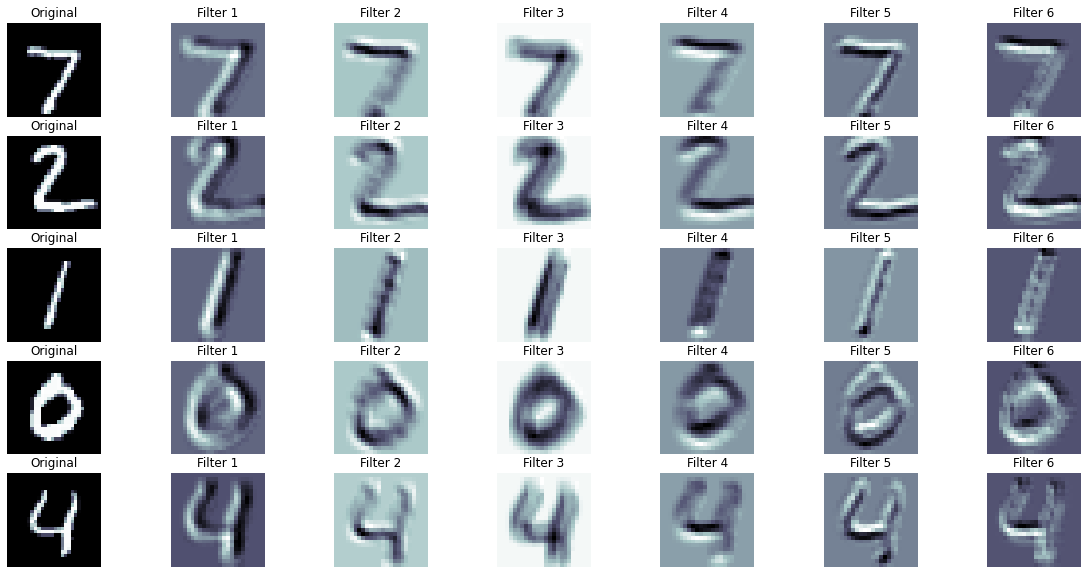

In [121]:
N_IMAGES = 5

images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]
filters = mnist_lenet.conv1.weight.data

plot_filtered_images(images, filters)

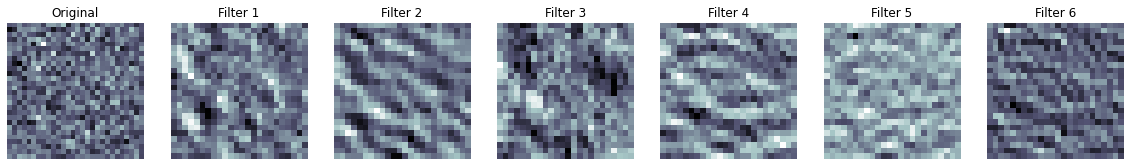

In [122]:
plot_filtered_images([best_image], filters)

Finally, we'll plot the actual filters themselves.

In [123]:
def plot_filters(filters):

    filters = filters.cpu()

    n_filters = filters.shape[0]

    fig = plt.figure(figsize = (20, 10))

    for i in range(n_filters):

        ax = fig.add_subplot(1, n_filters, i+1)
        ax.imshow(filters[i].squeeze(0), cmap = 'bone')
        ax.axis('off')

There are some patterns visible, but it's difficult to interpret what these filters have actually learned.

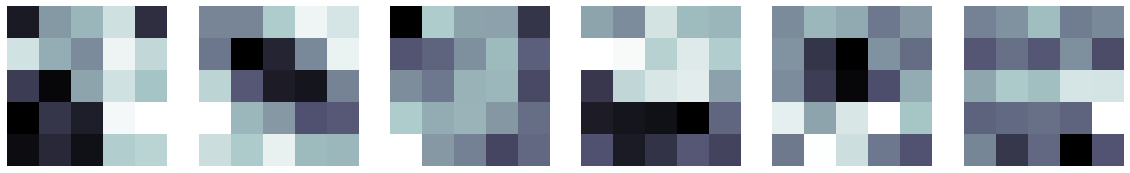

In [124]:
plot_filters(filters)


In the next notebook we'll implement another CNN, AlexNet, and finally move on to color images by using the CIFAR10 dataset.


### Credits
* [bentrevett](https://github.com/bentrevett/pytorch-image-classification/blob/master/2_lenet.ipynb)